In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [38]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import os
import cv2
from sklearn.model_selection import train_test_split
import PIL
from collections import Counter

from sklearn.metrics import classification_report
%matplotlib inline  

In [3]:
#VIDEOS_FOLDER = os.path.join('/tmp/', 'megapolis_football')
IMAGES_FOLDER  = os.path.join('/content/drive/My Drive/', 'megapolis_football', 'labeled_images')
INTERMEDIATE_FOLDER = os.path.join('/content/drive/My Drive/', 'megapolis_football', 'intermediate') 
MODEL_FOLDER = '/content/drive/My Drive/Models'
CACHE_FILE = os.path.join(INTERMEDIATE_FOLDER, 'cache_array.npz') 

In [4]:
HW = (80, 32) # Size of images to input
WH = (32, 80)
SEED = 2020

In [5]:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print(torch.cuda.get_device_name())

Tesla T4


In [150]:
# Model parameters
embedding_dims = 64
batch_size = 101
epochs = 100

In [151]:
cache = np.load(CACHE_FILE)
images = cache['images']
labels = cache['labels']
paths = cache['paths']
rgb_mean = cache['rgb_mean']
rgb_std = cache['rgb_std']


In [152]:
np.load(CACHE_FILE)['images'].shape

(503, 80, 32, 3)

In [153]:
def eliminate_rare(images, labels, paths):
    rare_labels =[l for l, count in Counter(labels).items() if count < 2] 
    rare_indexes = [] # Indexes of samples, where labels are rather rare
    if any(rare_labels):
        for j, l in tqdm(enumerate(labels)):
            if l in rare_labels:
                rare_indexes.append(j)        
    images = np.stack([ _ for (i, _) in enumerate(images) if i not in rare_indexes])
    labels = np.stack([ _ for (i, _) in enumerate(labels) if i not in rare_indexes])
    paths = np.stack( [ _ for (i, _) in enumerate(paths)  if i not in rare_indexes])
    return images, labels, paths

In [154]:
train_images, test_images, train_labels, test_labels, train_paths, test_paths = train_test_split(images, labels, paths, test_size=0.2, random_state=SEED)

In [155]:
train_images, train_labels, train_paths = eliminate_rare(train_images, train_labels, train_paths)
test_images, test_labels, test_paths = eliminate_rare(test_images, test_labels, test_paths)

In [156]:
class CachedDataset(Dataset):
    def __init__(self, images, labels, paths, return_paths=False):
        self.return_paths = return_paths
   
        self.images = torch.from_numpy(images.transpose(0,3,1,2)).float()
        self.labels = labels
        self.paths = paths
        self.index = np.arange(len(images))

        assert len(self.images) == len(self.labels) == len(self.index) == len(self.paths)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        anchor_label = self.labels[item]
        anchor_img = self.images[item]

        positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]
        if positive_list.any():
            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item]
        else:
            raise Exception('positive_list cannot be empty')
            
        negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
        if negative_list.any():
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item]
        else:
            raise Exception('negative_list cannot be empty')

        returned_path = self.paths[item] if self.return_paths else np.nan
        return anchor_img, positive_img, negative_img, anchor_label, returned_path        

In [157]:
train_ds = CachedDataset(train_images, train_labels, train_paths)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)  

In [158]:
test_ds = CachedDataset(test_images, test_labels, test_paths)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

## Define TripletLoss

In [159]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.25):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

## Define Neural Network

In [160]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16*2, 5, padding=2),   # (H, W)
            nn.PReLU(),
            nn.MaxPool2d(2),                  # (H // 2, W // 2)
            nn.Dropout(0.3),

            nn.Conv2d(16*2, 32*2, 5, padding=2),  # (H // 2, W // 2)
            nn.PReLU(),
            nn.MaxPool2d(2),                  # (H // 4, W // 4)
            nn.Dropout(0.3),

            nn.Conv2d(32*2, 64*2, 3, padding=1), # (H // 4, W // 4)
            nn.PReLU(),
            nn.MaxPool2d(2),                  # (H // 8, W // 8)
            nn.Dropout(0.3)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*2*(HW[0]//8)*(HW[1]//8), 256),
            nn.PReLU(),
            nn.Linear(256, emb_dim)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))
        x = self.fc(x)
        #x = nn.functional.normalize(x, p=1.0)
        return x

### weight initialize

In [161]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

### Create Instances
Use JIT compilation for high speed.

In [162]:
model = Network(embedding_dims)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

criterion = torch.jit.script(TripletLoss())

In [163]:
optimizer = optim.Adam(model.parameters(), lr=0.003)

## Training Loop

In [177]:

for epoch in tqdm(range(50), desc="Epochs"):
    running_loss = []
    model.train()
    for step, (anchor_img, positive_img, negative_img, anchor_label, path) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy() * anchor_img.shape[0] / len(train_ds))
    if (epoch+1) % 10 == 0:
        val_running_loss = []
        model.eval()
        with torch.no_grad():
            for step, (anchor_img, positive_img, negative_img, anchor_label, path) in enumerate(tqdm(test_loader, desc="Evaluating", leave=False)):
                anchor_img = anchor_img.to(device)
                positive_img = positive_img.to(device)
                negative_img = negative_img.to(device)
    
                anchor_out = model(anchor_img)
                positive_out = model(positive_img)
                negative_out = model(negative_img)
                
                loss = criterion(anchor_out, positive_out, negative_out)
                
                val_running_loss.append(loss.cpu().detach().numpy() * anchor_img.shape[0] / len(test_ds))

        print(f"\rEpoch: {epoch+1:3d}/{epochs:3d} - Train Loss: {np.sum(running_loss):.4f}, Val Loss: {np.sum(val_running_loss):.4f}", end='')
        #evaluate_and_plot(model, train_loader)


Epoch:  10/100 - Train Loss: 0.0128, Val Loss: 0.0504

Epoch:  20/100 - Train Loss: 0.0066, Val Loss: 0.0661

Epoch:  30/100 - Train Loss: 0.0142, Val Loss: 0.1988

Epoch:  40/100 - Train Loss: 0.0087, Val Loss: 0.0778

Epoch:  50/100 - Train Loss: 0.0021, Val Loss: 0.1655


In [165]:
running_loss, val_running_loss

([0.011408872411248102,
  0.009907504423192484,
  0.0031036877244785058,
  0.007780340569677638],
 [0.12927217781543732])

In [166]:
torch.save({"model_state_dict": model.state_dict(),
            "optimzier_state_dict": optimizer.state_dict()
           }, os.path.join(MODEL_FOLDER, f"trained_model_{embedding_dims}dim.pth"))

In [167]:
#model.load_state_dict(torch.load(os.path.join(MODEL_FOLDER, f"trained_model_{embedding_dims}dim.pth")))['model_state_dict'])

In [168]:
def evaluate(model, loader, display = True):
    results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for img, _, _, label, _ in tqdm(loader, desc="Evaluating"):
            results.append(model(img.to(device)).cpu().numpy())
            labels.append(label)
            
    results = np.concatenate(results)
    labels = np.concatenate(labels)
    if display:
        plt.figure(figsize=(15, 10), facecolor='azure')
        for label in np.unique(labels):
            tmp = results[labels==label]
            plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

        plt.legend()
        plt.show()
    return results, labels

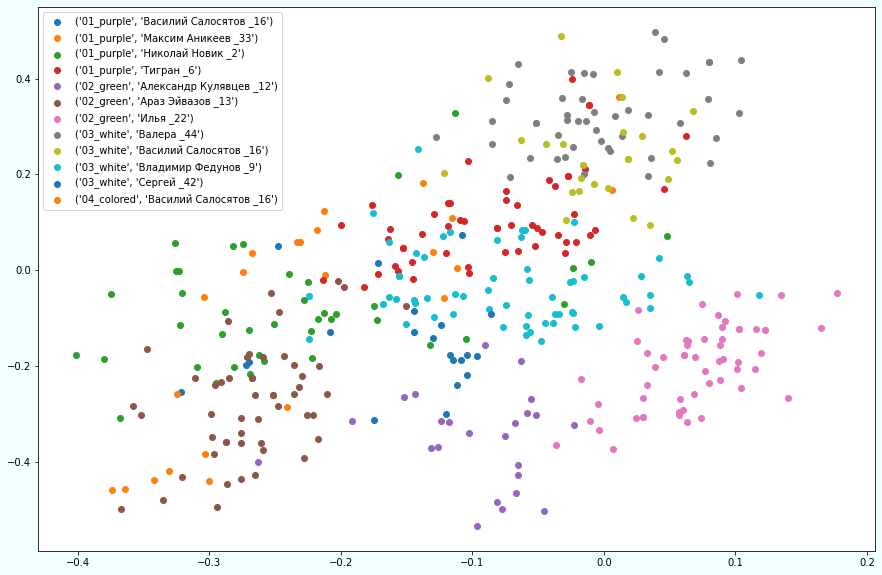

In [179]:
train_results, train_labels = evaluate(model, train_loader)

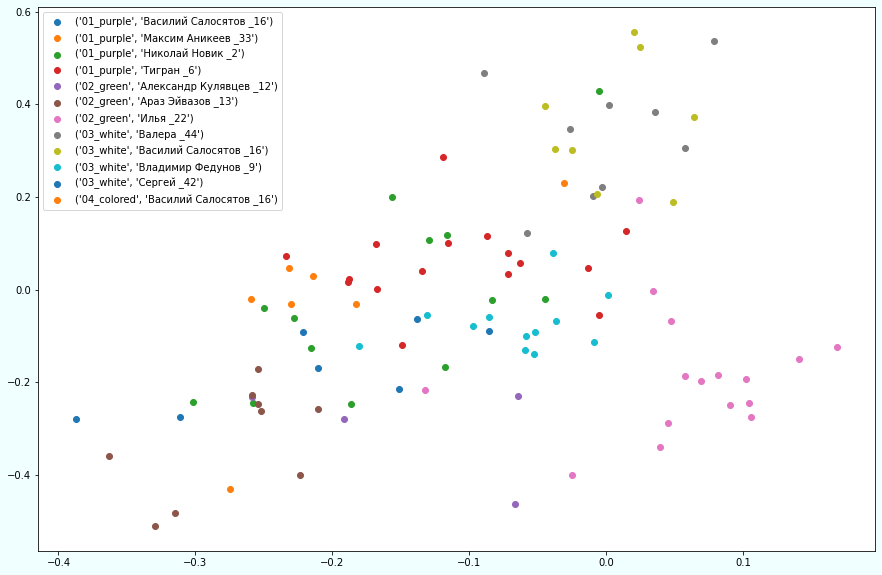

In [178]:
test_results, test_labels = evaluate(model, test_loader)

In [180]:
tree = XGBClassifier(seed=SEED)
tree.fit(train_results, train_labels)
predicted = tree.predict(test_results)
print(classification_report(test_labels, predicted))

                                          precision    recall  f1-score   support

 ('01_purple', 'Василий Салосятов _16')       1.00      0.50      0.67         4
     ('01_purple', 'Максим Аникеев _33')       0.44      0.80      0.57         5
      ('01_purple', 'Николай Новик _2')       0.83      0.77      0.80        13
              ('01_purple', 'Тигран _6')       0.82      0.88      0.85        16
  ('02_green', 'Александр Кулявцев _12')       1.00      0.75      0.86         4
       ('02_green', 'Араз Эйвазов _13')       0.90      1.00      0.95         9
                ('02_green', 'Илья _22')       0.93      0.88      0.90        16
              ('03_white', 'Валера _44')       0.89      0.89      0.89         9
  ('03_white', 'Василий Салосятов _16')       0.88      0.88      0.88         8
     ('03_white', 'Владимир Федунов _9')       0.92      0.92      0.92        12
             ('03_white', 'Сергей _42')       0.67      0.67      0.67         3
('04_colored', 

In [184]:
test_results.shape

(101, 64)

In [186]:
test_ds.index[test_labels != predicted]

array([ 1,  2,  4,  6, 13, 14, 18, 20, 33, 42, 44, 73, 76, 78, 93, 94])

In [193]:
ds = CachedDataset(test_images, test_labels, test_paths, return_paths=True)

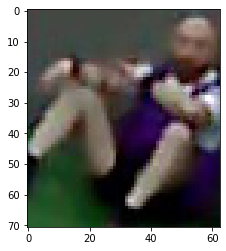

('01_purple', 'Тигран _6') ('01_purple', 'Николай Новик _2')


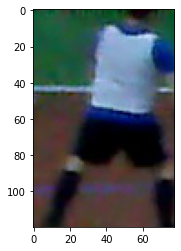

('03_white', 'Валера _44') ('01_purple', 'Тигран _6')


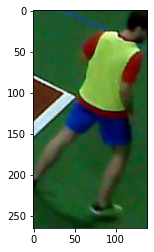

('02_green', 'Илья _22') ('03_white', 'Сергей _42')


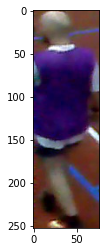

('01_purple', 'Тигран _6') ('01_purple', 'Максим Аникеев _33')


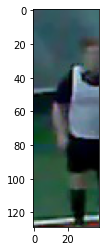

('03_white', 'Владимир Федунов _9') ('01_purple', 'Тигран _6')


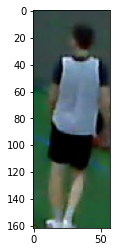

('03_white', 'Сергей _42') ('03_white', 'Владимир Федунов _9')


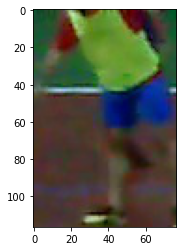

('02_green', 'Илья _22') ('03_white', 'Василий Салосятов _16')


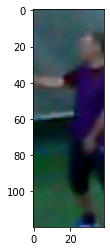

('01_purple', 'Николай Новик _2') ('01_purple', 'Максим Аникеев _33')


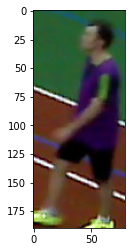

('01_purple', 'Василий Салосятов _16') ('01_purple', 'Максим Аникеев _33')


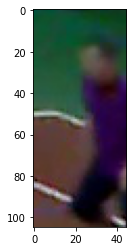

('01_purple', 'Николай Новик _2') ('01_purple', 'Тигран _6')


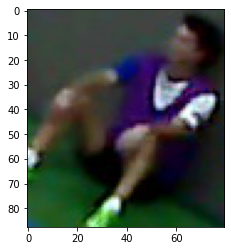

('01_purple', 'Максим Аникеев _33') ('01_purple', 'Николай Новик _2')


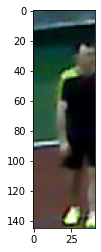

('04_colored', 'Василий Салосятов _16') ('02_green', 'Илья _22')


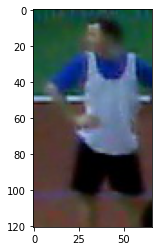

('03_white', 'Василий Салосятов _16') ('03_white', 'Валера _44')


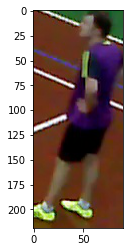

('01_purple', 'Василий Салосятов _16') ('01_purple', 'Максим Аникеев _33')


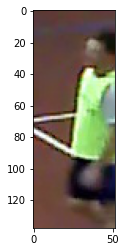

('02_green', 'Александр Кулявцев _12') ('02_green', 'Араз Эйвазов _13')


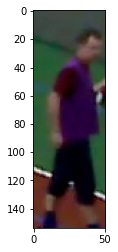

('01_purple', 'Николай Новик _2') ('01_purple', 'Максим Аникеев _33')


In [199]:
for ix in ds.index[test_labels != predicted]:
    i,_,_, l, p = ds[ix]
    
    pil_im = PIL.Image.open(p, 'r')
    plt.imshow(np.asarray(pil_im))
    plt.show()
    print(l, predicted[ix])

In [182]:
test_labels != predicted

array([ True, False, False,  True, False,  True, False,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True])

In [172]:
np.sum(tree.predict(train_results) != labels)

ValueError: ignored

In [ ]:
np.sum(tree.predict(test_results) == test_labels)/len(test_labels)

In [ ]:
proba = tree.predict_proba(test_results)[4]
plt.plot(proba)

In [ ]:
tree.predict(test_results)[4]

In [ ]:
tree.classes_

In [ ]:
test_labels[4]